In [ ]:
# most code from https://www.youtube.com/watch?v=Jwi6je8SrjQ

In [149]:
import numpy as np
import soundfile as sf
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from scipy.signal import resample

### Read in audiofiles

In [150]:
speech, speech_samplerate = sf.read('Sounds/00652.wav')
#speech, speech_samplerate = sf.read('Sounds/00328_0.64.wav')
noise, noise_samplerate = sf.read('Sounds/car_noise.wav')

# Find length of speech 
speech_len = len(speech)

# Ensure both files have the same sample rate
if speech_samplerate != noise_samplerate:
    speech_duration = speech_len/speech_samplerate
    target_length = int(speech_duration*noise_samplerate)
     # Trim or loop noise to match target_length
    if len(noise) >= target_length:
        noise = noise[:target_length]
    else:
        repeats = (target_length // len(noise)) + 1
        noise = np.tile(noise, (repeats, 1))[:target_length] if noise.ndim > 1 else np.tile(noise, repeats)[:target_length]
    # Now resample noise to match speech length and sample rate
    if noise.ndim > 1:
        noise = np.stack([
            resample(noise[:, ch], speech_len)
            for ch in range(noise.shape[1])
        ], axis=1)
    else:
        noise = resample(noise, speech_len)
    noise_samplerate = speech_samplerate  # Now sample rates match

# If sample rates already match, just trim or loop noise to match speech length
if len(noise) >= speech_len:
    noise_trimmed = noise[:speech_len]
else:
    repeats = (speech_len // len(noise)) + 1
    noise_trimmed = np.tile(noise, (repeats, 1))[:speech_len] if noise.ndim > 1 else np.tile(noise, repeats)[:speech_len]

# Save the trimmed noise
sf.write('noise_trimmed.wav', noise_trimmed, speech_samplerate)

### Create section of observed signal 

In [151]:
n = 500
a = 0.99
y = speech[0:n] + a * noise_trimmed[0:n, 0]  # Use left channel
#y = speech[0:n] + a * noise[0:n, 0]  # Use left channel

In [152]:
# Auto-covariance matrix
ycorr_long = np.convolve(y,np.flip(y), mode = 'full')
ycorr = ycorr_long[n-1:]
R = toeplitz(ycorr)

In [153]:
# Cross-correlation vector
ys_corr_long = np.convolve(y,np.flip(speech[0:n]), mode = 'full')
ys_corr = ys_corr_long[n-1:]

In [154]:
# Optimal filter coefficients
hopt = np.matmul(np.linalg.inv(R), ys_corr)

In [155]:
# Appy Filter
s_hat_long = np.convolve(y,hopt, mode = 'full')
s_hat = s_hat_long[0:n]

### Plot Signals

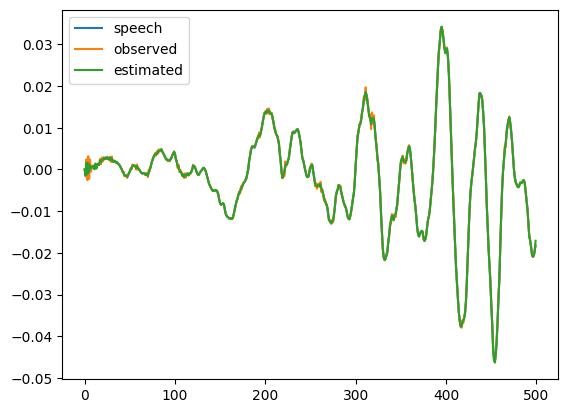

In [156]:
plt.plot(speech[0:n])
plt.plot(y[0:n])
plt.plot(s_hat)
plt.legend((['speech', 'observed', 'estimated']))
plt.show(block='True')